### Simulations for Berlin School of Mind and Brain
Author: Angel Bujalance Gómez
Contact: angelbujalanceg@gmail.com
LinkedIn:https://www.linkedin.com/in/angelbujalanceg/

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, glob
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.lines import Line2D

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [72]:
# criterion, bias, threshold, npar
def sample (n): #insert the number of participants and it will compute the important variables for them 
    #threshold is set to 0.5; criterion and bias have mean in 0
    mu_t = 0.65; sigma_t = 0.25; #the threshold is set to be high
    mu_c  = 0;  sigma_c = 0.3;
    #bias is set to 0 and it is ready to be computed in case of need 
    df0 = pd.DataFrame([])
    ndata = pd.DataFrame([])
    part_number = np.zeros(shape=( 1, 1))
    
    for subject in range(n):
        part_number = part_number + 1
        threshold = np.random.normal(mu_t, sigma_t, 1); criterion = np.random.normal(mu_c, sigma_c, 1); bias = 0;
        df1 = pd.DataFrame({'threshold':threshold, 'criterion':criterion, 'bias': bias})
        pardf = pd.DataFrame(part_number, columns = ['npar'])
        ndata = pd.concat([ndata, pardf], axis = 0)
        df0 = pd.concat([df0, df1], axis = 0)
    df = pd.concat([ndata, df0], axis = 1)
    return df

def log_reg_fit(x, f): # this function is used to calculate the log linear regression between two vectors
    # function by Alexis Pérez Bellido. Shared with me during the master
    reg = smf.glm(formula = f, data = x, family=sm.families.Binomial()).fit() 
    params = reg.params
    # concatenating parameters
    out = pd.DataFrame({'intercept':[params[0]] , 'weight':[params[1]]})
    return out #intercept + weight

In [73]:
a = sample(10)
a.head()

,npar,threshold,criterion,bias
0,1.0,0.328107,-0.247764,0
0,2.0,0.314773,-0.135604,0
0,3.0,0.804671,0.044061,0
0,4.0,0.565798,-0.386922,0
0,5.0,0.980473,-0.098656,0


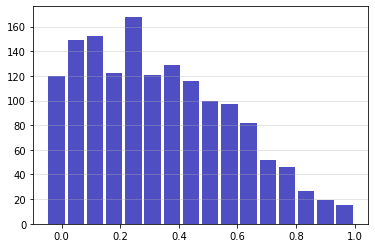

In [74]:
signal = 0.2; sigma = 0.35 # the overall level of signal is love, to make the perceptual decision process a bit hard
dv = np.random.normal(signal, sigma, 2000) # 2000 stimuli
dv = dv[ (dv >= -0.05) & (dv <= 1) ] # stimuli with negative or larger than 1 values were removed

plt.hist(dv, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85) #distribution of the "stimuli" depending on dv
plt.grid(axis='y', alpha=0.4)

In [75]:
n = 200 # 200 simulated participants will participate in the experiment
df = sample(n)
expectations = np.array([0.9, 0.6, 0.15, 0])

reps = expectations.shape[0]*dv.shape[0]; reps_dv = expectations.shape[0]*n; reps_ex = dv.shape[0]*n

dv_df = pd.DataFrame(dv, columns = ['dv']); dv_df = pd.concat([dv_df]*reps_dv).sort_index()
exp_df = pd.DataFrame(expectations, columns = ['expectations']); exp_df = pd.concat([exp_df]*reps_ex).sort_index()
dfa = pd.concat([df]*reps).sort_index()

exp_df.reset_index(drop=True, inplace=True); dv_df.reset_index(drop=True, inplace=True); dfa.reset_index(drop=True, inplace=True)

df = pd.concat([dfa, exp_df, dv_df], axis = 1)


df.head(5)

,npar,threshold,criterion,bias,expectations,dv
0,1.0,0.821326,-0.026797,0,0.9,0.754326
1,2.0,0.587656,0.161355,0,0.9,0.754326
2,3.0,0.672819,0.357582,0,0.9,0.754326
3,4.0,0.149138,-0.144579,0,0.9,0.754326
4,5.0,0.969313,0.299000,0,0.9,0.754326


In [76]:
print(dfa.shape)
print(dv_df.shape)
print(exp_df.shape)
print(df.shape)

(1212000, 4)
(1212000, 1)
(1212000, 1)
(1212000, 6)


In [77]:
### MODEL ###

df['deci'] = 0
df.loc[(( df.expectations*0.1 + df.dv + df.criterion) > df.threshold - df.threshold * df.expectations)  , 'deci'] = 1

df['rdeci'] = df.threshold + df.criterion + df.expectations*1

In [78]:
df.head()

,npar,threshold,criterion,bias,expectations,dv,deci,rdeci
0,1.0,0.821326,-0.026797,0,0.9,0.754326,1,1.694529
1,2.0,0.587656,0.161355,0,0.9,0.754326,1,1.649011
2,3.0,0.672819,0.357582,0,0.9,0.754326,1,1.930401
3,4.0,0.149138,-0.144579,0,0.9,0.754326,1,0.904560
4,5.0,0.969313,0.299000,0,0.9,0.754326,1,2.168313


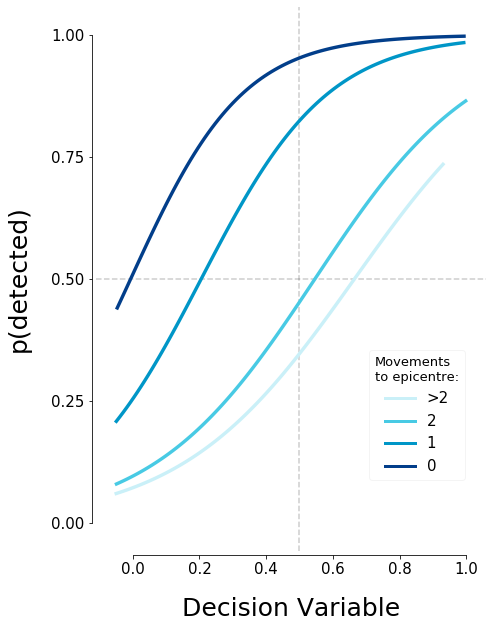

In [93]:
plt.subplots(ncols = 1, figsize = (7,10))

xpct_labels = np.unique(df.expectations) #expectations
npar_labels = np.unique(df.npar) #npar

mycol = ["#caf0f8", "#48cae4", "#0096c7", '#023e8a']
sns.set_palette(mycol)

ax = plt.axvline(0.5, ls='--', color= 'black', alpha=0.2)
ax = plt.axhline(0.5, ls='--', color= 'black', alpha=0.2)

for cell in xpct_labels: #for loop to compute the plot by the average sample
    sns.set_palette(mycol)
    ax = sns.regplot(x="dv", y="deci",  data=df.loc[df.expectations == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, n_boot=1,  label=cell,  truncate=True, line_kws ={'lw':3.4}); #mean by participant
sns.despine(offset=4, trim=True);
plt.ylabel('p(detected)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) #labelpad is the space between the label and the axis
plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); plt.xticks(np.arange(0, 1.1, step=0.2), fontsize = 15)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['>2', '2', '1', '0']; plt.legend(lines, labels, bbox_to_anchor=(0.68,0.25), fontsize=15, title = 'Movements\nto epicentre:', title_fontsize =13, framealpha= 0.2)


In [81]:
formula = "deci ~ dv"

log_reg_xpct = df.groupby(['expectations']).apply(log_reg_fit, formula)
log_reg_xpct.reset_index(inplace = True)
log_reg_xpct = log_reg_xpct.assign(movements = ['3', '2', '1', '0']) 
log_reg_xpct.tail(5)

,expectations,level_1,intercept,weight,movements
0,0.00,0,-2.551001,3.838074,3
1,0.15,0,-2.240670,4.102334,2
2,0.60,0,-1.075934,5.242832,1
3,0.90,0,0.037780,5.935858,0


In [82]:
fig = go.Figure()

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.45, y0=0, x1= 3.45, y1=0, 
              line=dict(color="#595858", width=2.2,))

dat = log_reg_xpct.loc[log_reg_xpct.expectations ==0.9,:]
fig.add_trace(go.Bar(y=dat['weight'], x=dat['movements'],
    name='0.9', marker_color='#023e8a'))

dat = log_reg_xpct.loc[log_reg_xpct.expectations ==0.6,:]
fig.add_trace(go.Bar(y=dat['weight'], x=dat['movements'],
    name='.6', marker_color='#0096c7'))

dat = log_reg_xpct.loc[log_reg_xpct.expectations ==0.15,:]
fig.add_trace(go.Bar(y=dat['weight'], x=dat['movements'],
    name='.15', marker_color='#48cae4'))

dat = log_reg_xpct.loc[log_reg_xpct.expectations ==0, :]
fig.add_trace(go.Bar(y=dat['weight'], x=dat['movements'],
    name='0', marker_color='#caf0f8'))

#fig.update_layout(barmode='group', xaxis_tickangle=-45)

fig.update_layout(
    boxgroupgap=0 # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2, 3], ticktext=['0', '1', '2', '>2'], tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=18))
fig.update_yaxes(tickvals= [0,2,4,6], ticktext=['0', '2', '4', '6', '8'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(yaxis_title="Beta Weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242" ))
fig.update_layout(xaxis_title="Distance from the epicentre of the face (in movements)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242" ))

fig.update_traces(showlegend=False)

fig['layout']['yaxis'].update(range=[-0.01, 6.02]);

fig.show()

In [94]:
fig.write_html(r"C:\Users\Angel\Dropbox\Documents academics\berlinWeightSimulation.html")
# change the path to file